In [47]:
import notebook_env
import importlib
importlib.reload(notebook_env)
from notebook_env import *

In [2]:
importlib.reload(refine_train)
importlib.reload(ode_models)
importlib.reload(odenet_cifar10)
importlib.reload(datasets)

<module 'odenet.datasets' from '/home/ubuntu/afq_odenet/ODENet/odenet/datasets.py'>

# Refinement with Euler and RK4

In [2]:
legend_name = lambda fname : re.search(r"ARCH(.*)", fname)[1]

In [125]:
dirs = glob('results/*CIFAR*-*Backprop*')
dirs = sorted(dirs, key = lambda x : os.stat(x).st_mtime)[:]
results = { name: torch.load(name) for name in dirs }
dirs

['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet

In [126]:
df = pd.DataFrame(columns=["scheme", "variant", "time_d","refine epochs","final_time_d","depth","nsteps","accuracy","final time/epoch (S)", "total time (m)"])
for name, result in results.items():
    try:
        args = PostPack(name)
    except Exception as e:
        print(name)
        raise e
    if len(result.test_acc) < 159:
        acc = "NaN"
    else:
        acc = max(list(zip(*result.test_acc))[1])
    if not args.use_skip_init:
        var = "BatchNorm"
    else:
        var = "SkipInit"
    df.loc[len(df)] = \
        [args.scheme, var, args.initial_time_d, args.refine, args.final_time_d, args.final_time_d*2*3 + 1 + 2 + 2 + 1,
                    args.n_steps_per, acc, result.epoch_times[-1], sum(result.epoch_times)/60.0]
df.sort_values('accuracy')


,scheme,variant,time_d,refine epochs,final_time_d,depth,nsteps,accuracy,final time/epoch (S),total time (m)
34,euler,SkipInit,12,[],12,78,1,0.9054,46.681769,133.127765
0,euler,BatchNorm,1,[],1,12,1,0.9060,9.820485,26.063286
37,euler,SkipInit,2,[],2,18,1,0.9083,11.253361,30.648844
36,rk4_classic,SkipInit,12,[],12,78,1,0.9091,132.893103,357.856191
1,rk4_classic,BatchNorm,1,[],1,12,1,0.9091,14.865958,43.555413
41,euler,SkipInit,2,"[90, 130]",8,54,1,0.9109,26.158741,39.108096
33,rk4_classic,SkipInit,6,[],6,42,1,0.9117,57.158879,181.809700
44,rk4_classic,SkipInit,2,"[90, 130]",8,54,1,0.9127,72.795490,111.393333
39,euler,SkipInit,2,"[40, 60]",8,54,1,0.9134,25.283692,55.439916
30,euler,SkipInit,6,[],6,42,1,0.9136,27.161397,77.122023


In [127]:
_=df.loc[df.variant=='BatchNorm'].sort_values('accuracy')[["scheme","time_d","refine epochs","final_time_d","depth","accuracy","total time (m)"]]
_

,scheme,time_d,refine epochs,final_time_d,depth,accuracy,total time (m)
0,euler,1,[],1,12,0.9060,26.063286
1,rk4_classic,1,[],1,12,0.9091,43.555413
2,euler,2,[],2,18,0.9173,37.296441
4,rk4_classic,2,[],2,18,0.9187,68.630306
6,rk4_classic,3,[],3,24,0.9232,98.669537
15,euler,2,"[50, 100]",8,54,0.9254,48.078189
3,euler,3,[],3,24,0.9263,45.030018
10,euler,1,"[30, 45, 60]",8,54,0.9266,55.714782
24,rk4_classic,2,"[60, 120]",8,54,0.9272,177.474040
25,rk4_classic,2,"[50, 100]",8,54,0.9274,191.232651


In [59]:
print(_.to_latex(index=False))

\begin{tabular}{lllllrr}
\toprule
      scheme & time\_d &         refine epochs & final\_time\_d & depth &  accuracy &  total time (m) \\
\midrule
       euler &      1 &                    [] &            1 &    12 &    0.9060 &       26.063286 \\
 rk4\_classic &      1 &                    [] &            1 &    12 &    0.9091 &       43.555413 \\
       euler &      2 &                    [] &            2 &    18 &    0.9173 &       37.296441 \\
 rk4\_classic &      2 &                    [] &            2 &    18 &    0.9187 &       68.630306 \\
 rk4\_classic &      3 &                    [] &            3 &    24 &    0.9232 &       98.669537 \\
       euler &      2 &             [50, 100] &            8 &    54 &    0.9254 &       48.078189 \\
       euler &      3 &                    [] &            3 &    24 &    0.9263 &       45.030018 \\
       euler &      1 &          [30, 45, 60] &            8 &    54 &    0.9266 &       55.714782 \\
 rk4\_classic &      2 &         

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9168


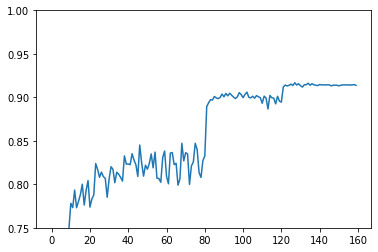

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9136


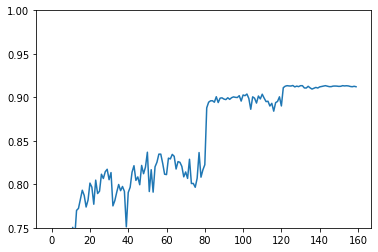

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9183


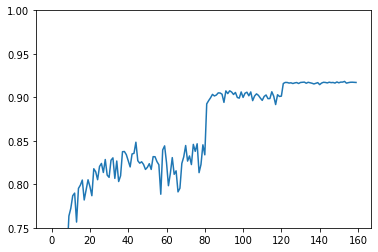

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9138


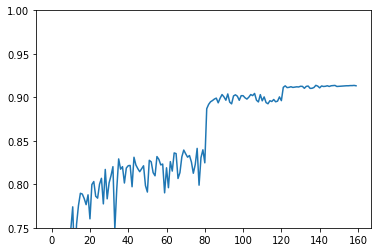

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9117


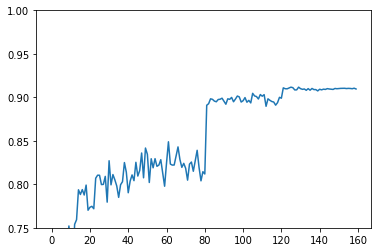

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-12-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9054


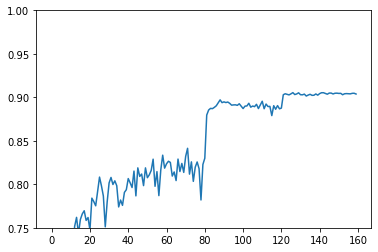

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9144


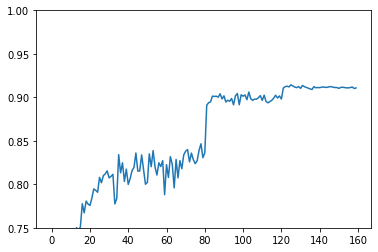

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-12-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9091


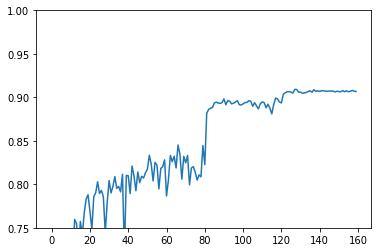

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9083


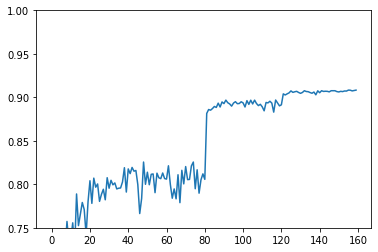

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9144


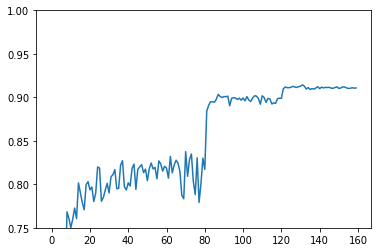

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[40, 60]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9134


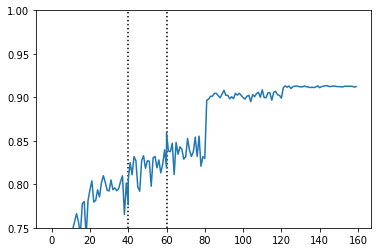

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9162


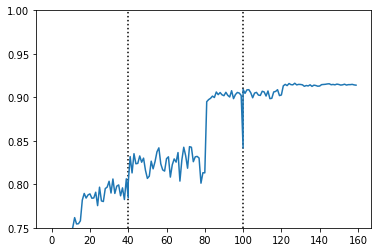

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9109


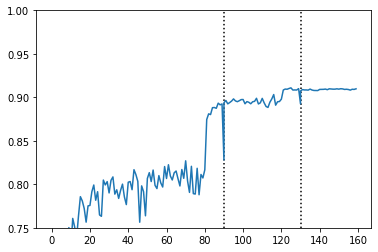

results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 60]-0.1-Backprop-NormalInit-SEED-1.pkl 0.9194


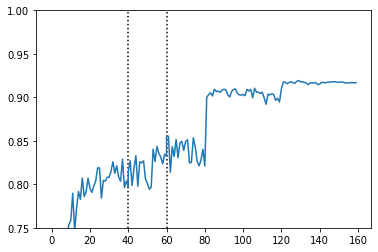

In [61]:
for name, result in results.items():
    #plt.plot(result.train_acc, label=legend_name(name))
    args = PostPack(name)
    if not args.use_skip_init: continue
    x,y = zip(*result.test_acc)
    plt.figure()
    plt.plot(x,y, '-', label=legend_name(name))
    try:
        x,y = zip(*result.train_acc)
        plt.plot(x,y, '--', label=legend_name(name))
    except: pass
    print((name),
          max(list(zip(*result.test_acc))[1]),)
          #max(list(zip(*result.train_acc))[1]))
    plt.vlines(args.refine,0,1, linestyle='dotted')
    plt.ylim(0.75,1)
    plt.show()
    plt.close('all')
    # plt.legend(loc=(0,-0.8))

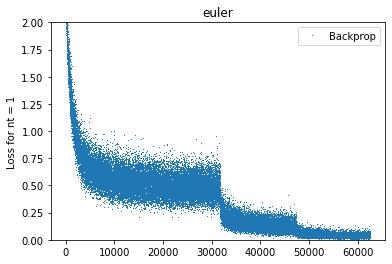

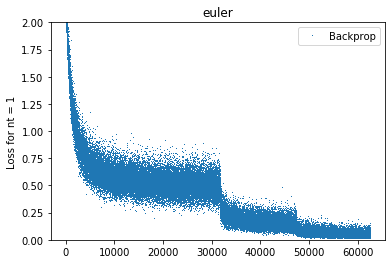

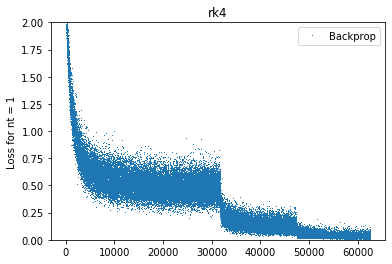

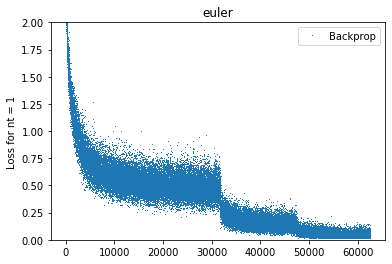

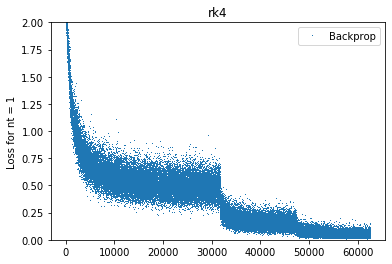

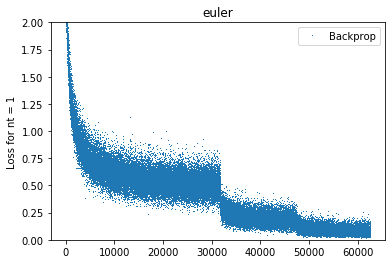

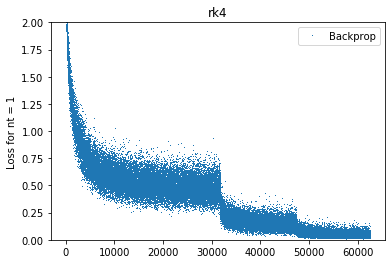

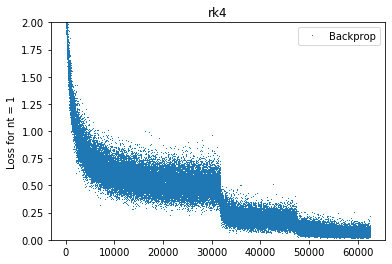

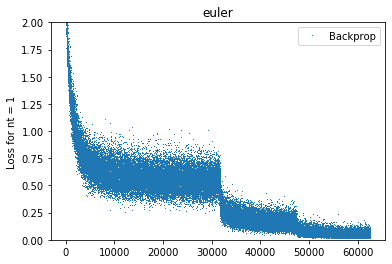

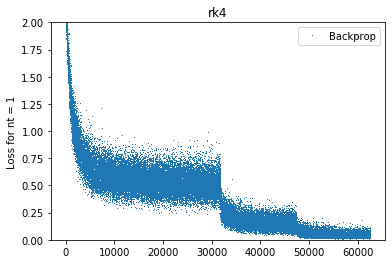

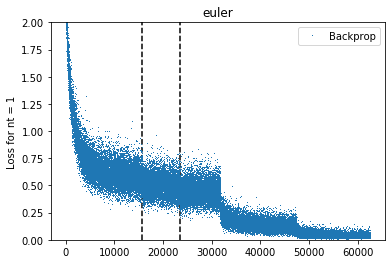

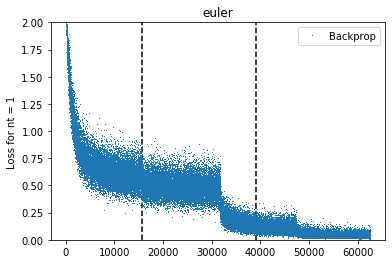

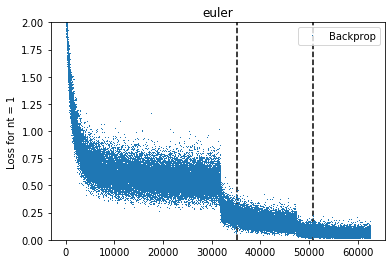

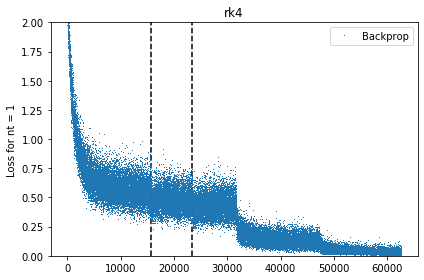

In [62]:
# plt.figure(figsize=(8,8))
for i,(name, result) in enumerate(results.items()):
    if "euler" in name:
        horiz = 0
    else:
        horiz = 1
    args = PostPack(name)
    if not args.use_skip_init: continue
    vert = 0
    # plt.subplot(3,2,1+horiz+2*vert)
    plt.figure()
    if horiz==0 and vert==0:
        plt.title("euler")
    if horiz==1 and vert==0:
        plt.title("rk4")
    if vert==2:
        plt.xlabel("step number")
    plt.ylabel(f"Loss for nt = { vert+1}")
    plt.plot(result.losses,
             '-' if "Adjoint" in name else ',',
             label="Adjoint" if "Adjoint" in name else "Backprop")
    plt.vlines(result.refine_steps, 0,2, linestyle='dashed')
    plt.legend()
    plt.ylim(0.,2)
plt.tight_layout()


# Plot their weights

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30, 40, 50]-0.1-Backprop-NormalInit-SEED-1.pkl


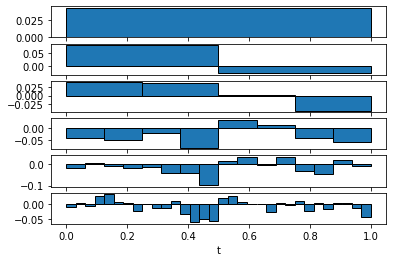

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl


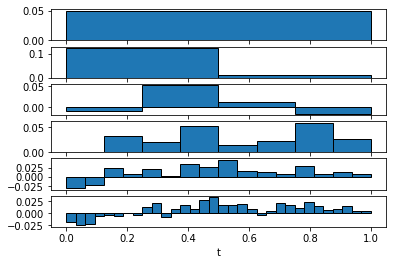

In [128]:
for name,result in results.items():
    args = PostPack(name)
    if len(args.refine)<5: continue
    i,j=0,0
    for a,b in [(2,2)]: #np.ndindex(result.model_list[0].net[2].net.L1.weight.shape[-2:]):
        print(name)
        plotting.plot_weights_over_time(
            result.model_list,
            lambda x : x.net[5].net.L1.weight[:,i,j,a,b].cpu(),
            lambda x : x.net[5].ts.cpu())


# Manifestation Invariance

In [90]:
sdb = SimDataDB("results/manifestation_study.sqlite")

In [91]:
refset,trainset,trainloader,testset,testloader = \
    datasets.get_dataset("CIFAR10",root='../data/')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [92]:
@sdb.Decorate(
    "fmnist",
    [("network","STRING"),("scheme","STRING"),("num_time","INT"),],
    [("train_acc","INT")])
@torch.no_grad()
def calc_acc_for_scheme_nt(name, scheme, nt):
    mod = results[name].model_list[-1]
    mod.eval()
    set_ode_config(mod, nt, scheme)
    return [refine_train.calculate_accuracy(mod, testloader)]

CREATE TABLE IF NOT EXISTS fmnist ( network STRING, scheme STRING, num_time INT, train_acc INT, timestamp VARCHAR(30), runtime FLOAT );


In [129]:
test_sweep = defaultdict( lambda : {} )
with torch.no_grad():
    for name, result in results.items():
        accs_for_scheme = {}
        for scheme in ('euler', 'midpoint','rk4','rk4_classic'):
            accs = []
            for nt in progress( range(1, 41, 1), f"{legend_name(name)}, {scheme}"):
                accs.append((nt, calc_acc_for_scheme_nt(name, scheme, nt)[0]))
            accs_for_scheme[scheme] = accs
        test_sweep[name].update(accs_for_scheme)



-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 40/40 [00:00<00:00, 1632.50it/s]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 40/40 [00:00<00:00, 1675.38it/s]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 40/40 [00:00<00:00, 1680.98it/s]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic: 100%|██████████| 40/40 [00:00<00:00, 737.15it/s]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 40/40 [00:00<00:00, 1658.52it/s]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 40/40 [00:00<00:00, 1639.55it/s]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.1513, datetime.datetime(2020, 5, 23, 17, 50, 23, 549673), 1.4863619804382324]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   5%|▌         | 2/40 [00:02<00:56,  1.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.2388, datetime.datetime(2020, 5, 23, 17, 50, 25, 47662), 1.4670302867889404]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   8%|▊         | 3/40 [00:04<00:55,  1.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.3753, datetime.datetime(2020, 5, 23, 17, 50, 26, 526391), 1.4918313026428223]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  10%|█         | 4/40 [00:06<00:54,  1.52s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.5318, datetime.datetime(2020, 5, 23, 17, 50, 28, 29807), 1.5688552856445312]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  12%|█▎        | 5/40 [00:07<00:56,  1.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.6407, datetime.datetime(2020, 5, 23, 17, 50, 29, 610224), 1.8398208618164062]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  15%|█▌        | 6/40 [00:09<00:59,  1.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.6583, datetime.datetime(2020, 5, 23, 17, 50, 31, 460681), 2.0489933490753174]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  18%|█▊        | 7/40 [00:12<01:03,  1.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.7734, datetime.datetime(2020, 5, 23, 17, 50, 33, 520855), 2.287189483642578]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  20%|██        | 8/40 [00:14<01:07,  2.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.8401, datetime.datetime(2020, 5, 23, 17, 50, 35, 818212), 2.566715717315674]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  22%|██▎       | 9/40 [00:17<01:12,  2.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.8341, datetime.datetime(2020, 5, 23, 17, 50, 38, 394922), 2.81341552734375]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  25%|██▌       | 10/40 [00:20<01:16,  2.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.8585, datetime.datetime(2020, 5, 23, 17, 50, 41, 218596), 3.070760726928711]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  28%|██▊       | 11/40 [00:24<01:20,  2.79s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.8662, datetime.datetime(2020, 5, 23, 17, 50, 44, 299096), 3.317305088043213]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  30%|███       | 12/40 [00:27<01:24,  3.02s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.8788, datetime.datetime(2020, 5, 23, 17, 50, 47, 626768), 3.572761297225952]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  32%|███▎      | 13/40 [00:31<01:28,  3.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.8879, datetime.datetime(2020, 5, 23, 17, 50, 51, 209516), 3.8302505016326904]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  35%|███▌      | 14/40 [00:35<01:31,  3.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.9017, datetime.datetime(2020, 5, 23, 17, 50, 55, 50388), 4.069475889205933]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  38%|███▊      | 15/40 [00:39<01:34,  3.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.9025, datetime.datetime(2020, 5, 23, 17, 50, 59, 130191), 4.369693994522095]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  40%|████      | 16/40 [00:44<01:36,  4.03s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 16, 0.9149, datetime.datetime(2020, 5, 23, 17, 51, 3, 510406), 4.603254556655884]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  42%|████▎     | 17/40 [00:49<01:38,  4.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 17, 0.9149, datetime.datetime(2020, 5, 23, 17, 51, 8, 123836), 4.82269811630249]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  45%|████▌     | 18/40 [00:54<01:39,  4.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 18, 0.9178, datetime.datetime(2020, 5, 23, 17, 51, 12, 956868), 5.0748560428619385]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  48%|████▊     | 19/40 [00:59<01:39,  4.76s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 19, 0.9168, datetime.datetime(2020, 5, 23, 17, 51, 18, 41721), 5.326327800750732]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  50%|█████     | 20/40 [01:05<01:40,  5.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 20, 0.917, datetime.datetime(2020, 5, 23, 17, 51, 23, 378255), 5.584843397140503]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  52%|█████▎    | 21/40 [01:11<01:39,  5.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 21, 0.9198, datetime.datetime(2020, 5, 23, 17, 51, 28, 973228), 5.828993320465088]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  55%|█████▌    | 22/40 [01:17<01:39,  5.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 22, 0.9194, datetime.datetime(2020, 5, 23, 17, 51, 34, 812511), 6.087085723876953]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  57%|█████▊    | 23/40 [01:23<01:37,  5.76s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 23, 0.9245, datetime.datetime(2020, 5, 23, 17, 51, 40, 909538), 6.3370161056518555]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  60%|██████    | 24/40 [01:30<01:36,  6.02s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 24, 0.9248, datetime.datetime(2020, 5, 23, 17, 51, 47, 256604), 6.608281850814819]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  62%|██████▎   | 25/40 [01:37<01:34,  6.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 25, 0.9241, datetime.datetime(2020, 5, 23, 17, 51, 53, 875889), 6.859149932861328]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  65%|██████▌   | 26/40 [01:44<01:31,  6.52s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 26, 0.9267, datetime.datetime(2020, 5, 23, 17, 52, 0, 745696), 7.086479425430298]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  68%|██████▊   | 27/40 [01:51<01:27,  6.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 27, 0.9283, datetime.datetime(2020, 5, 23, 17, 52, 7, 842423), 7.335724592208862]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  70%|███████   | 28/40 [01:59<01:24,  7.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 28, 0.9292, datetime.datetime(2020, 5, 23, 17, 52, 15, 190143), 7.574913024902344]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  72%|███████▎  | 29/40 [02:07<01:19,  7.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 29, 0.9295, datetime.datetime(2020, 5, 23, 17, 52, 22, 775877), 7.853631973266602]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  75%|███████▌  | 30/40 [02:15<01:15,  7.52s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 30, 0.9313, datetime.datetime(2020, 5, 23, 17, 52, 30, 640036), 8.094511270523071]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  78%|███████▊  | 31/40 [02:23<01:09,  7.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 31, 0.9313, datetime.datetime(2020, 5, 23, 17, 52, 38, 744929), 8.351967811584473]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  80%|████████  | 32/40 [02:32<01:04,  8.03s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 32, 0.9338, datetime.datetime(2020, 5, 23, 17, 52, 47, 108059), 8.607147932052612]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  82%|████████▎ | 33/40 [02:41<00:57,  8.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 33, 0.9318, datetime.datetime(2020, 5, 23, 17, 52, 55, 725732), 8.859699964523315]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  85%|████████▌ | 34/40 [02:50<00:51,  8.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 34, 0.931, datetime.datetime(2020, 5, 23, 17, 53, 4, 596294), 9.103873491287231]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  88%|████████▊ | 35/40 [02:59<00:43,  8.79s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 35, 0.9308, datetime.datetime(2020, 5, 23, 17, 53, 13, 710598), 9.375930309295654]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  90%|█████████ | 36/40 [03:09<00:36,  9.03s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 36, 0.9305, datetime.datetime(2020, 5, 23, 17, 53, 23, 96594), 9.593729496002197]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  92%|█████████▎| 37/40 [03:19<00:27,  9.29s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 37, 0.9298, datetime.datetime(2020, 5, 23, 17, 53, 32, 700910), 9.867161512374878]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  95%|█████████▌| 38/40 [03:29<00:19,  9.54s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 38, 0.9301, datetime.datetime(2020, 5, 23, 17, 53, 42, 578443), 10.1096510887146]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  98%|█████████▊| 39/40 [03:39<00:09,  9.79s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 39, 0.9316, datetime.datetime(2020, 5, 23, 17, 53, 52, 698258), 10.359580993652344]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 40/40 [03:50<00:00,  5.75s/it]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   0%|          | 0/40 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 40, 0.9304, datetime.datetime(2020, 5, 23, 17, 54, 3, 68348), 10.56929326057434]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   2%|▎         | 1/40 [00:01<00:57,  1.47s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.1038, datetime.datetime(2020, 5, 23, 17, 54, 13, 650293), 1.4621620178222656]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   5%|▌         | 2/40 [00:03<00:57,  1.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.3093, datetime.datetime(2020, 5, 23, 17, 54, 15, 123506), 1.575425148010254]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   8%|▊         | 3/40 [00:05<01:00,  1.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.3623, datetime.datetime(2020, 5, 23, 17, 54, 16, 710603), 1.962646722793579]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  10%|█         | 4/40 [00:07<01:07,  1.86s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.5807, datetime.datetime(2020, 5, 23, 17, 54, 18, 683758), 2.357858896255493]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  12%|█▎        | 5/40 [00:10<01:15,  2.15s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.5795, datetime.datetime(2020, 5, 23, 17, 54, 21, 51874), 2.8228800296783447]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  15%|█▌        | 6/40 [00:13<01:25,  2.50s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.7545, datetime.datetime(2020, 5, 23, 17, 54, 23, 885488), 3.298657178878784]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  18%|█▊        | 7/40 [00:17<01:34,  2.88s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.7802, datetime.datetime(2020, 5, 23, 17, 54, 27, 194730), 3.7413246631622314]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  20%|██        | 8/40 [00:21<01:44,  3.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.8125, datetime.datetime(2020, 5, 23, 17, 54, 30, 946530), 4.196253299713135]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  22%|██▎       | 9/40 [00:26<01:54,  3.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.8459, datetime.datetime(2020, 5, 23, 17, 54, 35, 153182), 4.64703893661499]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  25%|██▌       | 10/40 [00:31<02:03,  4.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.8616, datetime.datetime(2020, 5, 23, 17, 54, 39, 809736), 5.142838478088379]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  28%|██▊       | 11/40 [00:37<02:14,  4.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.8746, datetime.datetime(2020, 5, 23, 17, 54, 44, 962914), 5.827909231185913]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  30%|███       | 12/40 [00:43<02:24,  5.15s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.8867, datetime.datetime(2020, 5, 23, 17, 54, 50, 801361), 6.322978973388672]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  32%|███▎      | 13/40 [00:50<02:32,  5.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.8983, datetime.datetime(2020, 5, 23, 17, 54, 57, 134722), 6.795331716537476]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  35%|███▌      | 14/40 [00:57<02:37,  6.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.906, datetime.datetime(2020, 5, 23, 17, 55, 3, 940432), 6.982222318649292]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  38%|███▊      | 15/40 [01:04<02:41,  6.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.9112, datetime.datetime(2020, 5, 23, 17, 55, 10, 933155), 7.456761837005615]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  40%|████      | 16/40 [01:12<02:45,  6.90s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 16, 0.9178, datetime.datetime(2020, 5, 23, 17, 55, 18, 399854), 7.878965616226196]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  42%|████▎     | 17/40 [01:20<02:48,  7.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 17, 0.9127, datetime.datetime(2020, 5, 23, 17, 55, 26, 288980), 8.339200496673584]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  45%|████▌     | 18/40 [01:29<02:50,  7.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 18, 0.9161, datetime.datetime(2020, 5, 23, 17, 55, 34, 638501), 8.722864627838135]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  48%|████▊     | 19/40 [01:38<02:51,  8.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 19, 0.9119, datetime.datetime(2020, 5, 23, 17, 55, 43, 373175), 9.163738489151001]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  50%|█████     | 20/40 [01:48<02:54,  8.70s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 20, 0.9184, datetime.datetime(2020, 5, 23, 17, 55, 52, 548573), 9.911118268966675]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  52%|█████▎    | 21/40 [01:59<02:54,  9.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 21, 0.9186, datetime.datetime(2020, 5, 23, 17, 56, 2, 472374), 10.314879894256592]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  55%|█████▌    | 22/40 [02:09<02:52,  9.59s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 22, 0.9228, datetime.datetime(2020, 5, 23, 17, 56, 12, 797969), 10.49459171295166]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  57%|█████▊    | 23/40 [02:21<02:52, 10.15s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 23, 0.9236, datetime.datetime(2020, 5, 23, 17, 56, 23, 304684), 11.459217548370361]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  60%|██████    | 24/40 [02:32<02:50, 10.67s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 24, 0.921, datetime.datetime(2020, 5, 23, 17, 56, 34, 774440), 11.863124132156372]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  62%|██████▎   | 25/40 [02:45<02:47, 11.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 25, 0.9278, datetime.datetime(2020, 5, 23, 17, 56, 46, 648202), 12.355857372283936]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  65%|██████▌   | 26/40 [02:58<02:43, 11.68s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 26, 0.9255, datetime.datetime(2020, 5, 23, 17, 56, 59, 14660), 12.851966381072998]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  68%|██████▊   | 27/40 [03:11<02:38, 12.17s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 27, 0.9255, datetime.datetime(2020, 5, 23, 17, 57, 11, 876911), 13.300902366638184]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  70%|███████   | 28/40 [03:25<02:31, 12.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 28, 0.9288, datetime.datetime(2020, 5, 23, 17, 57, 25, 188136), 13.760333776473999]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  72%|███████▎  | 29/40 [03:39<02:24, 13.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 29, 0.9306, datetime.datetime(2020, 5, 23, 17, 57, 38, 958994), 14.224997282028198]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  75%|███████▌  | 30/40 [03:54<02:16, 13.61s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 30, 0.9307, datetime.datetime(2020, 5, 23, 17, 57, 53, 194157), 14.738252401351929]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  78%|███████▊  | 31/40 [04:09<02:06, 14.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 31, 0.932, datetime.datetime(2020, 5, 23, 17, 58, 7, 942656), 15.220216274261475]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  80%|████████  | 32/40 [04:25<01:56, 14.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 32, 0.9335, datetime.datetime(2020, 5, 23, 17, 58, 23, 172792), 15.66524624824524]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  82%|████████▎ | 33/40 [04:41<01:45, 15.06s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 33, 0.9322, datetime.datetime(2020, 5, 23, 17, 58, 38, 848503), 16.185123443603516]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  85%|████████▌ | 34/40 [04:57<01:33, 15.52s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 34, 0.9327, datetime.datetime(2020, 5, 23, 17, 58, 55, 44563), 16.592788219451904]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  88%|████████▊ | 35/40 [05:15<01:19, 15.99s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 35, 0.9297, datetime.datetime(2020, 5, 23, 17, 59, 11, 647705), 17.068355321884155]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  90%|█████████ | 36/40 [05:31<01:05, 16.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 36, 0.9313, datetime.datetime(2020, 5, 23, 17, 59, 28, 726912), 16.905717134475708]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  92%|█████████▎| 37/40 [05:49<00:49, 16.61s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 37, 0.9315, datetime.datetime(2020, 5, 23, 17, 59, 45, 643162), 17.384453058242798]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  95%|█████████▌| 38/40 [06:07<00:33, 16.97s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 38, 0.9307, datetime.datetime(2020, 5, 23, 18, 0, 3, 38118), 17.79778289794922]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  98%|█████████▊| 39/40 [06:25<00:17, 17.35s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 39, 0.9306, datetime.datetime(2020, 5, 23, 18, 0, 20, 847226), 18.22736930847168]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 40/40 [06:44<00:00, 10.10s/it]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   0%|          | 0/40 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 40, 0.9304, datetime.datetime(2020, 5, 23, 18, 0, 39, 87009), 18.68854784965515]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   2%|▎         | 1/40 [00:01<01:01,  1.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.1108, datetime.datetime(2020, 5, 23, 18, 0, 57, 788615), 1.5624651908874512]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   5%|▌         | 2/40 [00:04<01:09,  1.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.3102, datetime.datetime(2020, 5, 23, 18, 0, 59, 361464), 2.4593286514282227]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   8%|▊         | 3/40 [00:07<01:25,  2.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.7009, datetime.datetime(2020, 5, 23, 18, 1, 1, 831772), 3.4263288974761963]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  10%|█         | 4/40 [00:11<01:45,  2.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.8358, datetime.datetime(2020, 5, 23, 18, 1, 5, 268485), 4.378457069396973]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  12%|█▎        | 5/40 [00:17<02:08,  3.67s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.8874, datetime.datetime(2020, 5, 23, 18, 1, 9, 657287), 5.345605850219727]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  15%|█▌        | 6/40 [00:23<02:31,  4.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.9133, datetime.datetime(2020, 5, 23, 18, 1, 15, 13206), 6.294442176818848]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  18%|█▊        | 7/40 [00:30<02:55,  5.30s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.9154, datetime.datetime(2020, 5, 23, 18, 1, 21, 318013), 7.271002292633057]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  20%|██        | 8/40 [00:39<03:18,  6.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.924, datetime.datetime(2020, 5, 23, 18, 1, 28, 599318), 8.239477157592773]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  22%|██▎       | 9/40 [00:48<03:39,  7.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.9269, datetime.datetime(2020, 5, 23, 18, 1, 36, 849308), 9.194047451019287]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  25%|██▌       | 10/40 [00:58<03:59,  8.00s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.9306, datetime.datetime(2020, 5, 23, 18, 1, 46, 53804), 10.098395347595215]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  28%|██▊       | 11/40 [01:09<04:18,  8.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.9329, datetime.datetime(2020, 5, 23, 18, 1, 56, 162890), 11.053152561187744]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  30%|███       | 12/40 [01:21<04:35,  9.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.9319, datetime.datetime(2020, 5, 23, 18, 2, 7, 226107), 11.987203598022461]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  32%|███▎      | 13/40 [01:34<04:50, 10.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.9335, datetime.datetime(2020, 5, 23, 18, 2, 19, 223640), 12.91487979888916]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  35%|███▌      | 14/40 [01:48<05:04, 11.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.9301, datetime.datetime(2020, 5, 23, 18, 2, 32, 149086), 13.927417755126953]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  38%|███▊      | 15/40 [02:03<05:16, 12.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.9297, datetime.datetime(2020, 5, 23, 18, 2, 46, 86864), 14.82571530342102]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  40%|████      | 16/40 [02:18<05:26, 13.60s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 16, 0.9334, datetime.datetime(2020, 5, 23, 18, 3, 0, 923218), 15.809015989303589]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  42%|████▎     | 17/40 [02:35<05:31, 14.42s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 17, 0.932, datetime.datetime(2020, 5, 23, 18, 3, 16, 744145), 16.312461853027344]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  45%|████▌     | 18/40 [02:52<05:34, 15.22s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 18, 0.9306, datetime.datetime(2020, 5, 23, 18, 3, 33, 67391), 17.066795110702515]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  48%|████▊     | 19/40 [03:10<05:36, 16.00s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 19, 0.9309, datetime.datetime(2020, 5, 23, 18, 3, 50, 144789), 17.829040050506592]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  50%|█████     | 20/40 [03:28<05:36, 16.82s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 20, 0.933, datetime.datetime(2020, 5, 23, 18, 4, 7, 984702), 18.71654438972473]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  52%|█████▎    | 21/40 [03:48<05:35, 17.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 21, 0.9329, datetime.datetime(2020, 5, 23, 18, 4, 26, 712024), 19.609103441238403]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  55%|█████▌    | 22/40 [04:09<05:33, 18.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 22, 0.934, datetime.datetime(2020, 5, 23, 18, 4, 46, 331570), 20.53302264213562]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  57%|█████▊    | 23/40 [04:30<05:29, 19.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 23, 0.9336, datetime.datetime(2020, 5, 23, 18, 5, 6, 875621), 21.44908356666565]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 24/40 [04:52<05:24, 20.29s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 24, 0.9322, datetime.datetime(2020, 5, 23, 18, 5, 28, 335241), 22.344440698623657]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  62%|██████▎   | 25/40 [05:16<05:17, 21.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 25, 0.9322, datetime.datetime(2020, 5, 23, 18, 5, 50, 690817), 23.28618597984314]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  65%|██████▌   | 26/40 [05:40<05:09, 22.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 26, 0.9319, datetime.datetime(2020, 5, 23, 18, 6, 13, 988431), 24.177348136901855]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  68%|██████▊   | 27/40 [06:05<04:59, 23.02s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 27, 0.9334, datetime.datetime(2020, 5, 23, 18, 6, 38, 177240), 25.16078281402588]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  70%|███████   | 28/40 [06:31<04:46, 23.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 28, 0.9338, datetime.datetime(2020, 5, 23, 18, 7, 3, 348488), 26.005250930786133]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  72%|███████▎  | 29/40 [06:58<04:33, 24.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 29, 0.9331, datetime.datetime(2020, 5, 23, 18, 7, 29, 364490), 26.950992107391357]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  75%|███████▌  | 30/40 [07:26<04:17, 25.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 30, 0.9335, datetime.datetime(2020, 5, 23, 18, 7, 56, 326729), 27.88713026046753]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  78%|███████▊  | 31/40 [07:55<03:59, 26.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 31, 0.9329, datetime.datetime(2020, 5, 23, 18, 8, 24, 225945), 28.737512826919556]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 32/40 [08:24<03:40, 27.56s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 32, 0.933, datetime.datetime(2020, 5, 23, 18, 8, 52, 974206), 29.68517279624939]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  82%|████████▎ | 33/40 [08:55<03:19, 28.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 33, 0.9327, datetime.datetime(2020, 5, 23, 18, 9, 22, 670498), 30.543670654296875]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  85%|████████▌ | 34/40 [09:26<02:56, 29.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 34, 0.9322, datetime.datetime(2020, 5, 23, 18, 9, 53, 225003), 31.472277402877808]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  88%|████████▊ | 35/40 [09:59<02:31, 30.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 35, 0.9335, datetime.datetime(2020, 5, 23, 18, 10, 24, 708113), 32.36500644683838]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  90%|█████████ | 36/40 [10:32<02:04, 31.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 36, 0.9326, datetime.datetime(2020, 5, 23, 18, 10, 57, 85295), 33.297666788101196]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  92%|█████████▎| 37/40 [11:06<01:36, 32.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 37, 0.9334, datetime.datetime(2020, 5, 23, 18, 11, 30, 394053), 34.247092723846436]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  95%|█████████▌| 38/40 [11:42<01:06, 33.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 38, 0.9328, datetime.datetime(2020, 5, 23, 18, 12, 4, 652347), 35.196656227111816]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  98%|█████████▊| 39/40 [12:18<00:33, 33.97s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 39, 0.9337, datetime.datetime(2020, 5, 23, 18, 12, 39, 860580), 36.132009983062744]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 40/40 [12:55<00:00, 19.38s/it]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:   0%|          | 0/40 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 40, 0.9343, datetime.datetime(2020, 5, 23, 18, 13, 16, 3708), 36.972408294677734]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:   2%|▎         | 1/40 [00:01<00:59,  1.52s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 1, 0.1131, datetime.datetime(2020, 5, 23, 18, 13, 52, 989877), 1.5144906044006348]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:   5%|▌         | 2/40 [00:03<01:07,  1.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 2, 0.4468, datetime.datetime(2020, 5, 23, 18, 13, 54, 514324), 2.3422160148620605]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:   8%|▊         | 3/40 [00:07<01:22,  2.22s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 3, 0.6426, datetime.datetime(2020, 5, 23, 18, 13, 56, 866702), 3.2658417224884033]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  10%|█         | 4/40 [00:11<01:41,  2.81s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 4, 0.8033, datetime.datetime(2020, 5, 23, 18, 14, 0, 142933), 4.17318320274353]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  12%|█▎        | 5/40 [00:16<02:02,  3.50s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 5, 0.821, datetime.datetime(2020, 5, 23, 18, 14, 4, 327380), 5.108975887298584]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  15%|█▌        | 6/40 [00:22<02:24,  4.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 6, 0.8617, datetime.datetime(2020, 5, 23, 18, 14, 9, 447164), 5.9960973262786865]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  18%|█▊        | 7/40 [00:29<02:46,  5.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 7, 0.8901, datetime.datetime(2020, 5, 23, 18, 14, 15, 453848), 6.887013673782349]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  20%|██        | 8/40 [00:37<03:07,  5.87s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 8, 0.8989, datetime.datetime(2020, 5, 23, 18, 14, 22, 351440), 7.7894957065582275]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  22%|██▎       | 9/40 [00:46<03:33,  6.88s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 9, 0.9093, datetime.datetime(2020, 5, 23, 18, 14, 30, 152141), 9.230673789978027]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  25%|██▌       | 10/40 [00:55<03:50,  7.68s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 10, 0.9107, datetime.datetime(2020, 5, 23, 18, 14, 39, 393397), 9.529475927352905]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  28%|██▊       | 11/40 [01:06<04:06,  8.50s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 11, 0.9169, datetime.datetime(2020, 5, 23, 18, 14, 48, 933075), 10.397084712982178]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  30%|███       | 12/40 [01:17<04:22,  9.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 12, 0.9177, datetime.datetime(2020, 5, 23, 18, 14, 59, 341249), 11.408299922943115]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  32%|███▎      | 13/40 [01:30<04:39, 10.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 13, 0.9264, datetime.datetime(2020, 5, 23, 18, 15, 10, 760933), 12.587990999221802]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  35%|███▌      | 14/40 [01:43<04:50, 11.16s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 14, 0.9271, datetime.datetime(2020, 5, 23, 18, 15, 23, 360938), 13.060112953186035]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  38%|███▊      | 15/40 [01:57<04:59, 12.00s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 15, 0.9292, datetime.datetime(2020, 5, 23, 18, 15, 36, 431962), 13.946228742599487]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  40%|████      | 16/40 [02:12<05:08, 12.86s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 16, 0.9321, datetime.datetime(2020, 5, 23, 18, 15, 50, 388580), 14.857208967208862]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  42%|████▎     | 17/40 [02:28<05:15, 13.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 17, 0.9296, datetime.datetime(2020, 5, 23, 18, 16, 5, 256651), 15.760082244873047]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  45%|████▌     | 18/40 [02:44<05:21, 14.61s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 18, 0.9289, datetime.datetime(2020, 5, 23, 18, 16, 21, 27363), 16.6344952583313]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  48%|████▊     | 19/40 [03:02<05:25, 15.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 19, 0.9289, datetime.datetime(2020, 5, 23, 18, 16, 37, 672526), 17.542065382003784]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  50%|█████     | 20/40 [03:20<05:27, 16.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 20, 0.9293, datetime.datetime(2020, 5, 23, 18, 16, 55, 226092), 18.437161207199097]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  52%|█████▎    | 21/40 [03:40<05:28, 17.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 21, 0.9301, datetime.datetime(2020, 5, 23, 18, 17, 13, 674111), 19.33647656440735]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  55%|█████▌    | 22/40 [04:00<05:26, 18.15s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 22, 0.9299, datetime.datetime(2020, 5, 23, 18, 17, 33, 21450), 20.18533992767334]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  57%|█████▊    | 23/40 [04:21<05:23, 19.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 23, 0.9292, datetime.datetime(2020, 5, 23, 18, 17, 53, 217408), 21.15170407295227]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  60%|██████    | 24/40 [04:44<05:24, 20.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 24, 0.93, datetime.datetime(2020, 5, 23, 18, 18, 14, 380143), 23.147700548171997]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  62%|██████▎   | 25/40 [05:08<05:21, 21.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 25, 0.9314, datetime.datetime(2020, 5, 23, 18, 18, 37, 539077), 24.0063579082489]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  65%|██████▌   | 26/40 [05:33<05:14, 22.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 26, 0.9322, datetime.datetime(2020, 5, 23, 18, 19, 1, 556314), 24.988024711608887]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  68%|██████▊   | 27/40 [05:58<05:01, 23.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 27, 0.9297, datetime.datetime(2020, 5, 23, 18, 19, 26, 555019), 24.797609329223633]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  70%|███████   | 28/40 [06:24<04:47, 23.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 28, 0.9299, datetime.datetime(2020, 5, 23, 18, 19, 51, 363760), 25.697603702545166]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  72%|███████▎  | 29/40 [06:50<04:32, 24.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 29, 0.9332, datetime.datetime(2020, 5, 23, 18, 20, 17, 72098), 26.612971782684326]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  75%|███████▌  | 30/40 [07:18<04:15, 25.58s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 30, 0.9321, datetime.datetime(2020, 5, 23, 18, 20, 43, 695933), 27.52357029914856]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  78%|███████▊  | 31/40 [07:46<03:57, 26.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 31, 0.9332, datetime.datetime(2020, 5, 23, 18, 21, 11, 230821), 28.269332885742188]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  80%|████████  | 32/40 [08:15<03:37, 27.22s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 32, 0.9329, datetime.datetime(2020, 5, 23, 18, 21, 39, 512465), 29.15845561027527]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  82%|████████▎ | 33/40 [08:45<03:16, 28.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 33, 0.9326, datetime.datetime(2020, 5, 23, 18, 22, 8, 681878), 30.08146095275879]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  85%|████████▌ | 34/40 [09:16<02:53, 28.93s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 34, 0.9331, datetime.datetime(2020, 5, 23, 18, 22, 38, 773720), 30.887882232666016]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  88%|████████▊ | 35/40 [09:49<02:30, 30.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 35, 0.9307, datetime.datetime(2020, 5, 23, 18, 23, 9, 672768), 32.84571313858032]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  90%|█████████ | 36/40 [10:23<02:04, 31.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 36, 0.9325, datetime.datetime(2020, 5, 23, 18, 23, 42, 529683), 33.78699970245361]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  92%|█████████▎| 37/40 [10:57<01:36, 32.24s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 37, 0.9339, datetime.datetime(2020, 5, 23, 18, 24, 16, 327483), 34.61280560493469]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  95%|█████████▌| 38/40 [11:33<01:06, 33.17s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 38, 0.9328, datetime.datetime(2020, 5, 23, 18, 24, 50, 951555), 35.328609228134155]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic:  98%|█████████▊| 39/40 [12:09<00:34, 34.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 39, 0.9324, datetime.datetime(2020, 5, 23, 18, 25, 26, 291513), 36.28104019165039]




-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl, rk4_classic: 100%|██████████| 40/40 [12:46<00:00, 19.17s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[20, 40, 60, 70, 80]-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4_classic', 40, 0.9329, datetime.datetime(2020, 5, 23, 18, 26, 2, 583549), 37.141547203063965]


This creates the plot for skipinit

{1: 0, 2: 1, 3: 2, 4: 3}
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFA

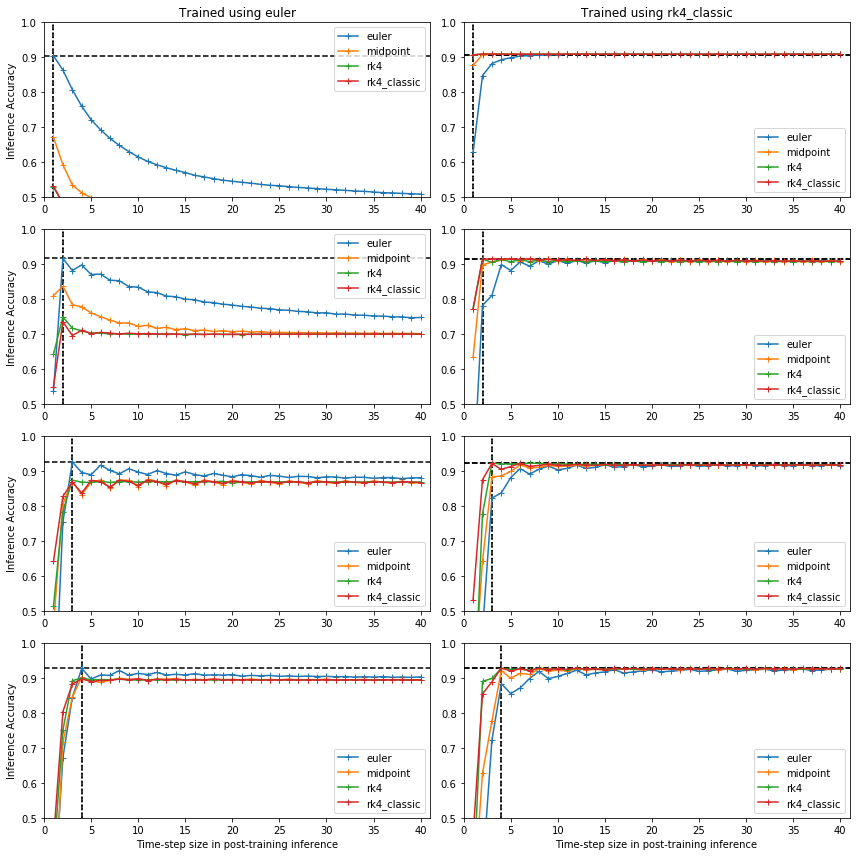

In [112]:
plt.figure(figsize=(12,12))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if args.use_skip_init: continue
    cols.append(args.final_time_d)
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if args.use_skip_init: continue
    print(name)
    col = cols[args.final_time_d]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme in args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,41.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.5,1.0)
    plt.xlim(0,41)
    plt.legend()
    if col == max(cols.values()):
        plt.xlabel('Time-step size in post-training inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel("Inference Accuracy")
plt.tight_layout()
plt.show()

This creates the plot for all of the backprops

## SkipInit

{2: 0, 4: 1, 6: 2, 8: 3, 12: 4}
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-6-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-12-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-8-1.0-1-piecewise-LEARN-0.1-160-[]-0.1-Backprop-NormalInit-SEED-1.p

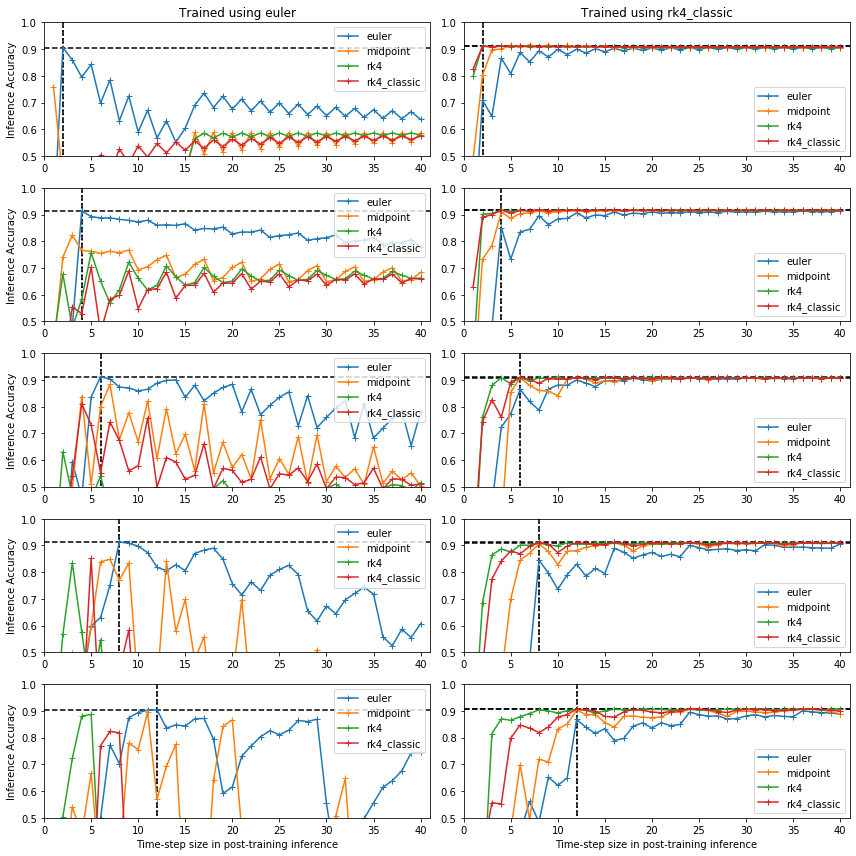

In [113]:
plt.figure(figsize=(12,12))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if not args.use_skip_init: continue
    cols.append(args.final_time_d)
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if len(args.refine)>0: continue
    if not args.use_skip_init: continue
    print(name)
    col = cols[args.final_time_d]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme in args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,41.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.5,1.0)
    plt.xlim(0,41)
    plt.legend()
    if col == max(cols.values()):
        plt.xlabel('Time-step size in post-training inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel("Inference Accuracy")
plt.tight_layout()
plt.show()

## Refinement + BatchNorm

{(10, 20, 30): 0, (10, 20, 30, 40, 50): 1, (10, 20, 40, 60): 2, (20, 30, 40): 3, (20, 40, 60, 70, 80): 4, (30, 40): 5, (30, 45, 60): 6, (30, 60): 7, (40, 80): 8, (45, 60): 9, (50, 100): 10, (60, 120): 11}
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[20, 30, 40]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-[30, 45, 60]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-[10, 20, 30]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-[30, 40]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEA

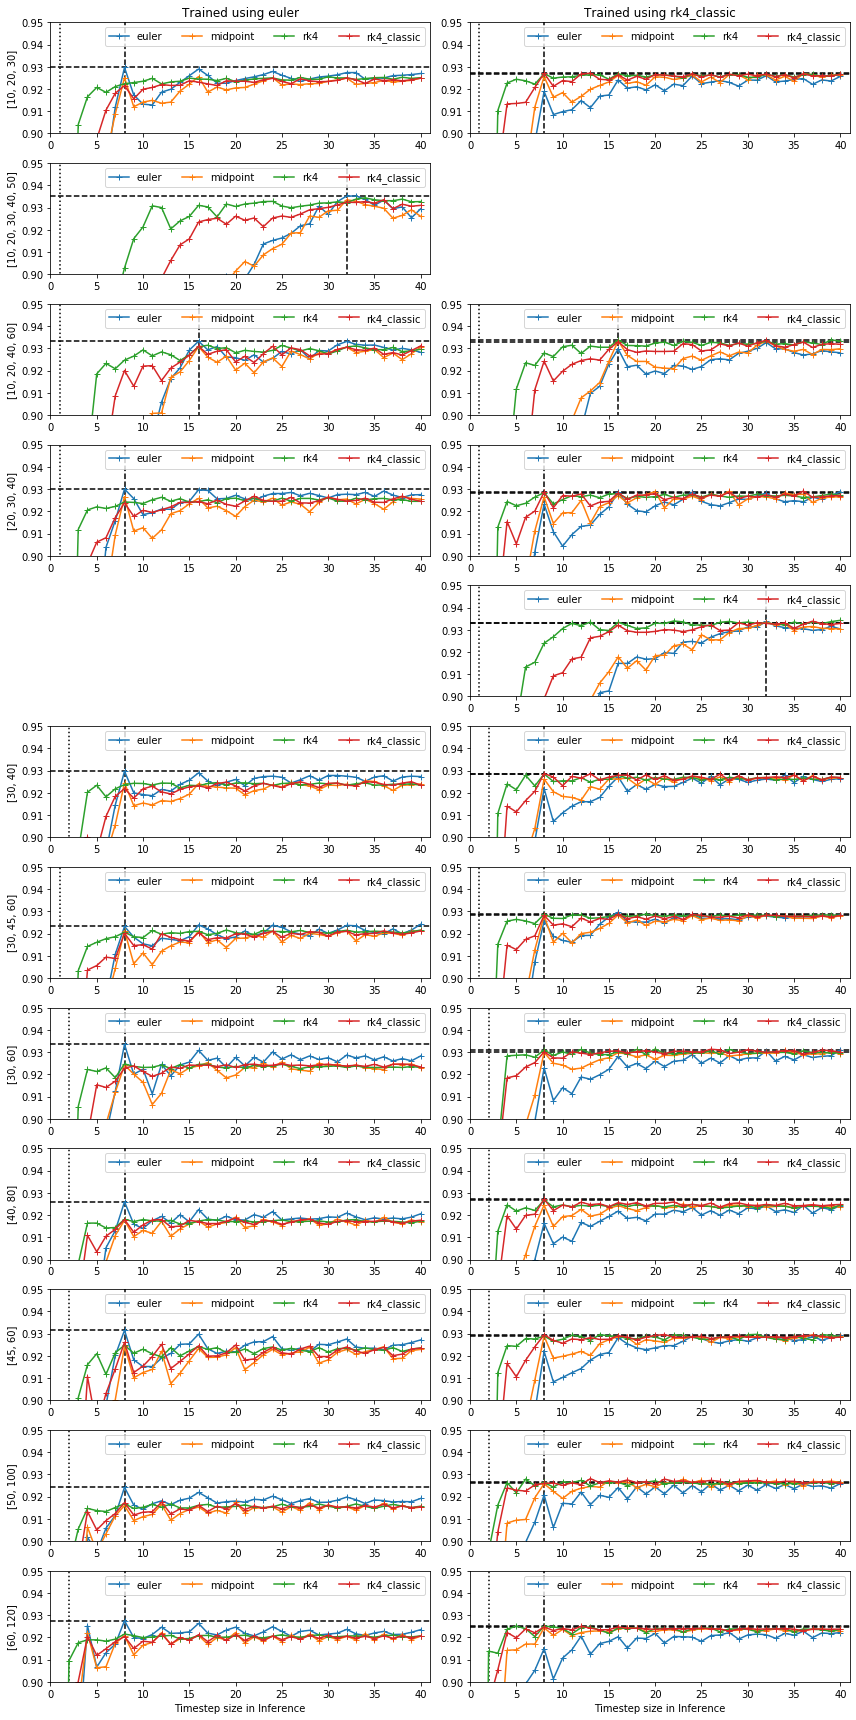

In [131]:
plt.figure(figsize=(12,24))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if args.use_skip_init: continue
    cols.append(tuple(args.refine))
cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if args.use_skip_init: continue
    print(name)
    col = cols[tuple(args.refine)]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme in args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,41.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.9,0.95)
    plt.xlim(0,41)
    plt.legend(ncol=4)
    if col == max(cols.values()):
        plt.xlabel(f'Timestep size in Inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel(f'{args.refine}')
plt.tight_layout()
plt.show()

## Refinement + SkipInit

{(40, 60): 0, (40, 100): 1, (90, 130): 2}
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[40, 60]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-euler-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 60]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[40, 100]-0.1-Backprop-NormalInit-SEED-1.pkl
results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-[90, 130]-0.1-Backprop-NormalInit-SEED-1.pkl


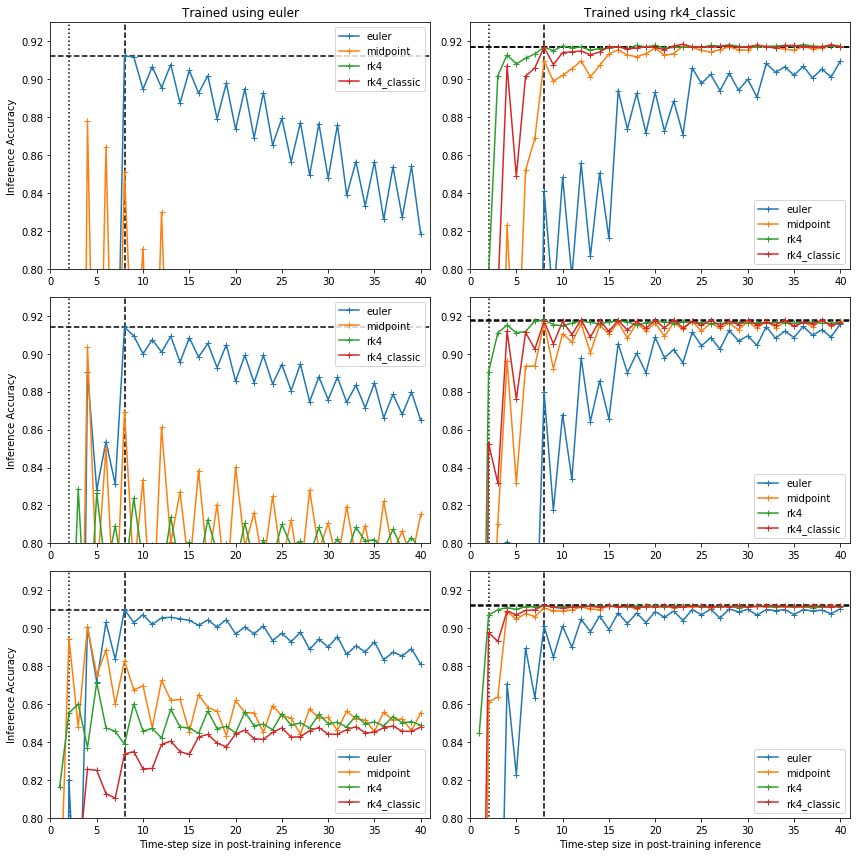

In [116]:
plt.figure(figsize=(12,12))
cols = []
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if not args.use_skip_init: continue
    cols.append(tuple(args.refine))

cols = { c:i for i,c in enumerate(sorted(set(cols))) }
print(cols)
for name, accs_for_scheme in test_sweep.items():
    args = PostPack(name)
    if not args.refine: continue
    if not args.use_skip_init: continue
    print(name)
    col = cols[tuple(args.refine)]
    horz = (0 if args.scheme=="euler" else 1)
    plt.subplot(len(cols), 2, 2*col + 1 + horz)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)
        if scheme in args.scheme:
            for i,nt in enumerate(x):
                if nt == args.final_time_d:
                    best_idx = i
                    break
            plt.hlines([y[best_idx]],0,41.0, linestyles='dashed')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([args.initial_time_d],0,1,linestyles='dotted')
    plt.vlines([args.final_time_d],0,1,linestyles='dashed')
    plt.ylim(0.8,0.93)
    plt.xlim(0,41)
    plt.legend()
    if col == max(cols.values()):
        plt.xlabel('Time-step size in post-training inference')
    if col == 0:
        plt.title("Trained using "+args.scheme)
    if horz == 0:
        plt.ylabel("Inference Accuracy")
plt.tight_layout()
plt.show()